In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import transpose
from numpy.linalg import inv
plt.style.use('ggplot')
from numpy import genfromtxt
import scipy.spatial.distance as cd

In [2]:
#reading in data
dtrain13_50 = np.array(genfromtxt('dtrain13_50.dat.txt'))
dtrain13_100 = np.array(genfromtxt('dtrain13_100.dat.txt'))
dtrain13_200 = np.array(genfromtxt('dtrain13_200.dat.txt'))
dtrain13_400 = np.array(genfromtxt('dtrain13_400.dat.txt'))

In [3]:
#the labels are current 1 and 3. They will be relabelled so that 1s remain 1s and 3s become -1s
dtrain13_50[dtrain13_50[:,0]==3, 0] = -1
dtrain13_100[dtrain13_100[:,0]==3, 0] = -1
dtrain13_200[dtrain13_200[:,0]==3, 0] = -1
dtrain13_400[dtrain13_400[:,0]==3, 0] = -1

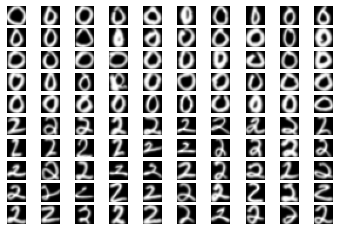

In [4]:
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(np.reshape(dtrain13_50[i,1:],(16,16)), cmap='gray')
    plt.grid(None)
    plt.axis('off')
    plt.savefig('Q2_1.png')

In [5]:
def FindWeight_Degree_LaplacianMatrices(dataset, K_par):
    """ function to return weight and degree matrices for dependant on K_par nearest neighbours
    INPUT:
        dataset: the dataset containing the coordinates (including the label colum) 
        K_par: the k parameter in knn. In our experiments it will be 3.
    OUTPUT:
        W: symmetric weight matrix with 1s in positions corresponding to a k-NN relationship (in either direction)
        and 0s everywhere else
        D: degree matrix found by summing over the columns of W
        L = graph laplacian matrix"""
    

    rows, cols = dataset.shape

    #we compute pairwise euclidean distances between rows of the dataset making sure to exclude
    #column indexed by 0 as that contains the labels
    temp=cd.cdist(dataset[:,1:],dataset[:,1:])

    #we sort the matrix rows and find the indices that sort them in ascending order
    sorted_ind=np.argsort(temp)
    indices_range = np.arange(rows)

    #we get rid of the the first column of these indices. This is because each row is distance 0 away from itself
    # so the sorting on row i returns row i in column indexed 0. We then keep the K_par columns of the
    #sorted_ind array as this gives us exactly the K_par closest rows to row i.
    k_nn_indices = sorted_ind[:,1:(K_par+1)]
    W = np.zeros((rows,rows))
    
    #we initialise weight matrix all 0s and set the positions corresponding to the k nearest neighbours of each row
    #to 1 inside the for loop
    for k in range(K_par):
        #each column j of k_nn_indices contains the jth closest neighbour for each row
        W[indices_range, k_nn_indices[:,k]] = 1
        #the relationship is undirected so we make sure the matrix is symmetrix by the below line of code
        W[ k_nn_indices[:,k], indices_range] = 1
    #we lastly contruct the degree matrix by filling the diagonal with the column sums of the weight matrix
    D = np.diag(np.sum(W, axis=1))
    L = D-W #graph laplacian matrix

    return W,D,L

def split_matrix(M,l):
    """ function to split matrix M into 4 blocks """
    Mll = M[:l,:l]
    Mlu = M[:l, l:]
    Mul = M[l:,:l]
    Muu = M[l:,l:]
    return Mll, Mlu, Mul, Muu


def random_setL(dataset, l):
    """ function to randomly sample l instances from each class and return a matrix X
    where the first 2l rows are the labelled set and the rest correspond to unlabelled set.
    Also returns the labels of the observed label set and the unobserved label set separately
    as fl and fu respectively."""
    rows,col = dataset.shape
    allindices = np.arange(rows)
    sampledindicesFirstclass = np.random.choice(np.where(dataset[:,0]==1)[0],l,replace=False)
    sampledindicesSecondclass = np.random.choice(np.where(dataset[:,0]==-1)[0],l,replace=False)
    sampledindices= np.concatenate((sampledindicesFirstclass,sampledindicesSecondclass))
    np.random.shuffle(sampledindices)
    nonsampledindices = np.delete(allindices,sampledindices)
    np.random.shuffle(nonsampledindices)
    newindexorder = np.concatenate((sampledindices,nonsampledindices))
    labels = np.array([dataset[newindexorder,[0]]]).T
    
    fl = labels[:2*l]
    fu = labels[2*l:]
    X = dataset[newindexorder,:]
    return X, fl,fu, sampledindices,nonsampledindices

In [6]:
MAXRUNS = 20
seminorm_errors = np.zeros((MAXRUNS, 4, 5))
laplaciankernel_errors = np.zeros((MAXRUNS, 4, 5))
np.random.seed(5)

dataset_counter=-1
for dataset in [dtrain13_50, dtrain13_100, dtrain13_200, dtrain13_400]:
    dataset_counter = dataset_counter + 1

    labels_counter=-1
    for l in [1,2,4,8,16]:
        labels_counter = labels_counter + 1
        
        for runs in range(MAXRUNS):
            X, fl_true, fu_true, indicesOfLabelledSet, indicesOfNonLabelledSet = random_setL(dataset, l)
            W,D,L = FindWeight_Degree_LaplacianMatrices(X,3)

            #laplacian seminorm interpolation using scheme from (Zhu et al. Semi-Supervised
            #Learning Using Gaussian Fields and Harmonic Functions) paper
            Wll, Wlu, Wul, Wuu = split_matrix(W,2*l)
            Dll, Dlu, Dul, Duu = split_matrix(D,2*l)

            ypred_laplacian_inter = np.sign((np.linalg.inv(Duu - Wuu))@Wul@fl_true)
            err = np.mean((ypred_laplacian_inter!=fu_true))
            seminorm_errors[runs, dataset_counter, labels_counter] = 100*err







            #laplacian kernel interpolation
            pseudo_invL = np.linalg.pinv(L)
            pseudo_invLll, pseudo_invLlu, pseudo_invLul, pseudo_invLuu = split_matrix(pseudo_invL,2*l)
            #kernel matrix given by pseudo inverse of Laplacian matrix entries correponding to
            #labelled set
            K = pseudo_invLll
            
            yl = fl_true 
            pseudo_invK = np.linalg.pinv(K)
            #print(K)


            alpha_star = (pseudo_invK@yl).T
            temp = pseudo_invL[:2*l,:]
            v = (alpha_star@temp).T
            ypred_laplacian_kernel_inter = (np.sign(v))[2*l:,:] #extracting predictions for unlabelled set
            err = np.mean((ypred_laplacian_kernel_inter!=fu_true))
            laplaciankernel_errors[runs, dataset_counter, labels_counter] = 100*err
        

In [7]:
np.mean(seminorm_errors,axis=0)

array([[18.52040816, 14.58333333,  7.7173913 ,  5.47619048,  3.82352941],
       [ 4.36868687,  5.25510204,  3.984375  ,  3.66847826,  2.97619048],
       [ 5.57788945,  3.5479798 ,  2.34693878,  1.9140625 ,  1.875     ],
       [13.45864662,  2.01005025,  1.49621212,  1.21173469,  1.015625  ]])

In [8]:
np.std(seminorm_errors,axis=0)

array([[11.61776258, 10.10470359,  5.50927213,  2.36302777,  2.64705882],
       [ 1.12110974,  2.60703802,  1.26804467,  1.15128914,  1.12938488],
       [ 8.05925819,  3.60808572,  1.74814711,  0.709725  ,  0.94485536],
       [12.1107622 ,  1.87266011,  0.58036187,  0.37077658,  0.23867582]])

In [9]:
np.mean(laplaciankernel_errors,axis=0)

array([[8.31632653, 7.03125   , 6.25      , 4.88095238, 3.45588235],
       [4.09090909, 4.59183673, 3.77604167, 3.55978261, 2.88690476],
       [1.80904523, 2.71464646, 2.05357143, 1.66666667, 1.5625    ],
       [1.84837093, 1.23115578, 1.27525253, 1.10969388, 0.98307292]])

In [10]:
np.std(laplaciankernel_errors,axis=0)

array([[4.11054809, 4.35604774, 3.84104967, 1.98848727, 1.75702987],
       [0.65656566, 1.38790515, 1.01361982, 1.10681586, 1.08579978],
       [0.40978659, 2.19693341, 0.51322448, 0.44652157, 0.45369043],
       [1.22965156, 0.32420824, 0.32166008, 0.17160235, 0.19949939]])